In [1]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from numpy import dstack

# Data Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin



import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib.pyplot import figure

print('libraries have imported ')

libraries have imported 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading Activities Samples

Data Preparation using standard method for LSTM.

In [3]:
path = "/content/drive/MyDrive/final_project/Experiment-3/Data" #set path
os.chdir(path)
results = pd.DataFrame([])
list_file = glob.glob("*.csv") #lisiting all the csv file samples
print(list_file)

['Lying_Amp_104.csv', 'Lying_Amp_209.csv', 'Empty_Amp_197.csv', 'Lying_Amp_121.csv', 'Empty_Amp_172.csv', 'Lying_Amp_204.csv', 'Lying_Amp_17.csv', 'Lying_Amp_110.csv', 'Empty_Amp_185.csv', 'Empty_Amp_32.csv', 'Lying_Amp_123.csv', 'Lying_Amp_162.csv', 'Lying_Amp_128.csv', 'Empty_Amp_182.csv', 'Empty_Amp_254.csv', 'Empty_Amp_65.csv', 'Empty_Amp_38.csv', 'Empty_Amp_250.csv', 'Lying_Amp_201.csv', 'Empty_Amp_211.csv', 'Lying_Amp_153.csv', 'Empty_Amp_266.csv', 'Lying_Amp_174.csv', 'Lying_Amp_197.csv', 'Lying_Amp_173.csv', 'Lying_Amp_208.csv', 'Lying_Amp_179.csv', 'Lying_Amp_186.csv', 'Empty_Amp_54.csv', 'Empty_Amp_25.csv', 'Lying_Amp_184.csv', 'Lying_Amp_119.csv', 'Lying_Amp_124.csv', 'Empty_Amp_37.csv', 'Empty_Amp_239.csv', 'Lying_Amp_127.csv', 'Empty_Amp_263.csv', 'Lying_Amp_106.csv', 'Empty_Amp_221.csv', 'Empty_Amp_61.csv', 'Empty_Amp_85.csv', 'Lying_Amp_166.csv', 'Empty_Amp_189.csv', 'Empty_Amp_92.csv', 'Empty_Amp_215.csv', 'Empty_Amp_170.csv', 'Empty_Amp_2.csv', 'Empty_Amp_28.csv', 'Emp

In [4]:
# function for reading CSV files
def reading_file(activity_csv):
    results = []
    for i in range(len(activity_csv)):
        df = pd.read_csv(activity_csv[i])
        results.append(df.values)
    return results

In [5]:
empty_csv = [i for i in list_file if i.startswith('Empty')] #list for empty csv files
lying_csv = [i for i in list_file if i.startswith('Lying')] #list for lying csv files
sitting_csv = [i for i in list_file if i.startswith('Sitting')] #list for sitting csv files
standing_csv = [i for i in list_file if i.startswith('Standing')] #list for satnding csv files
walking_csv = [i for i in list_file if i.startswith('Walking')] #list for walking csv files

In [6]:
#calling reading_file function
empty = reading_file(empty_csv)
lying = reading_file(lying_csv)
sitting = reading_file(sitting_csv)
standing = reading_file(standing_csv)
walking = reading_file(walking_csv)

In [7]:
#function for labeling the samples
def label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    return np.array(list_y).reshape(-1, 1)

In [8]:
walking_label = label(walking, 'walking')
empty_label = label(empty, 'empty')
lying_label = label(lying, 'lying')
sitting_label = label(sitting, 'sitting')
standing_label = label(standing, 'standing')

In [9]:
#concatenate all the samples into one np array
array_tuple = (empty, lying, sitting,standing, walking)
data_X = np.vstack(array_tuple)

#concatenate all the label into one array
label_tuple = (empty_label, lying_label, sitting_label,standing_label,  walking_label)
data_y = np.vstack(label_tuple)

#randomize the sample
from sklearn.utils import shuffle
data_X, data_y= shuffle(data_X, data_y)

 # Training and Testing Split

In [10]:
# training and testing
from sklearn.model_selection import train_test_split
X = data_X
y = data_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Data Standradization

In [11]:
class Standard_Scaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [12]:
sc = Standard_Scaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

# one-hot encoding for classes

In [13]:
#Encode categorical features (Activity Names) as a one-hot numeric array.

from sklearn.preprocessing import OneHotEncoder
en = OneHotEncoder()
y_train_en = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_en = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

# LSTM Model Design

In [14]:
activity_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(y_train_en.shape[1], activation='softmax')#Softmax converts a real vector to a vector of
                                                                  #categorical probabilities
                                                                    # output shape (number of classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

opt = keras.optimizers.Adam(learning_rate=1e-8)

In [17]:
activity_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_history = activity_model.fit(X_train, y_train_en, epochs= 150, validation_split=0.2,  batch_size=16, callbacks = [lr_schedule])

Epoch 1/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.1559 - loss: 1.8077 - val_accuracy: 0.0990 - val_loss: 1.7448 - learning_rate: 1.0000e-08
Epoch 2/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.1568 - loss: 1.7764 - val_accuracy: 0.0990 - val_loss: 1.7448 - learning_rate: 1.1220e-08
Epoch 3/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.1574 - loss: 1.7563 - val_accuracy: 0.0990 - val_loss: 1.7448 - learning_rate: 1.2589e-08
Epoch 4/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - accuracy: 0.1237 - loss: 1.7969 - val_accuracy: 0.0990 - val_loss: 1.7448 - learning_rate: 1.4125e-08
Epoch 5/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.1302 - loss: 1.7776 - val_accuracy: 0.0990 - val_loss: 1.7448 - learning_rate: 1.5849e-08
Epoch 6/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.1368 - loss: 1.7975 - val_accuracy: 0.0990 - val_loss: 1.7447 - learning_rate: 1.7783e-08
Epoch 7/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step

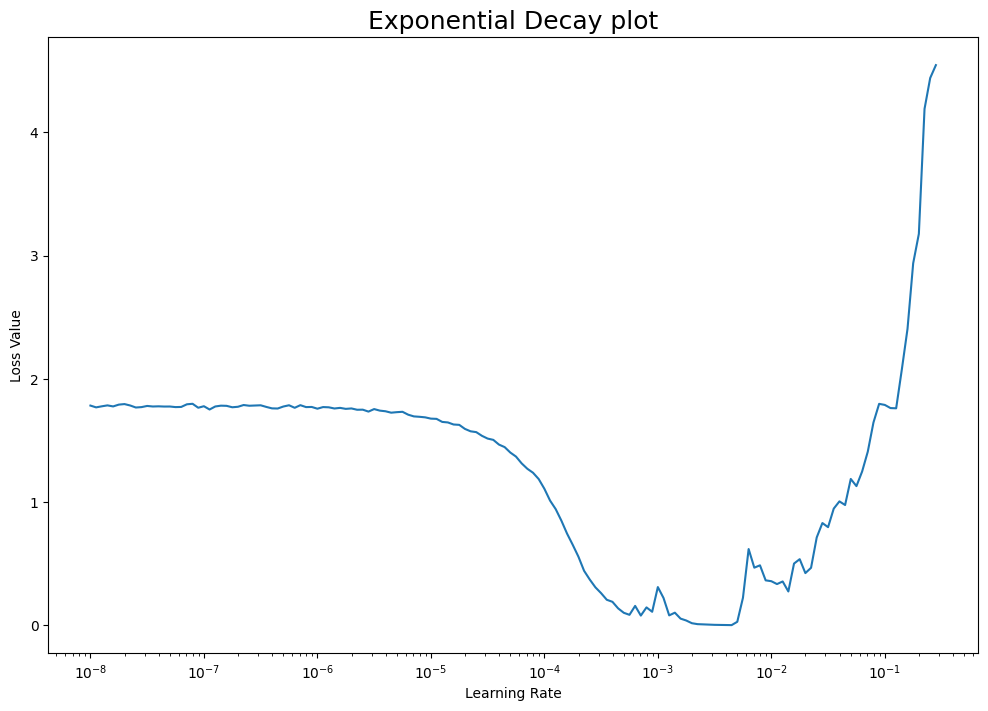

In [19]:
# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["learning_rate"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

# Model traing after choosing best learning rate

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(y_train_en.shape[1], activation='softmax'),#Softmax converts a real vector to a vector of
                                                                  #categorical probabilities
                                                                    # output shape (number of classes)
])
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])




## Model Summary Plot

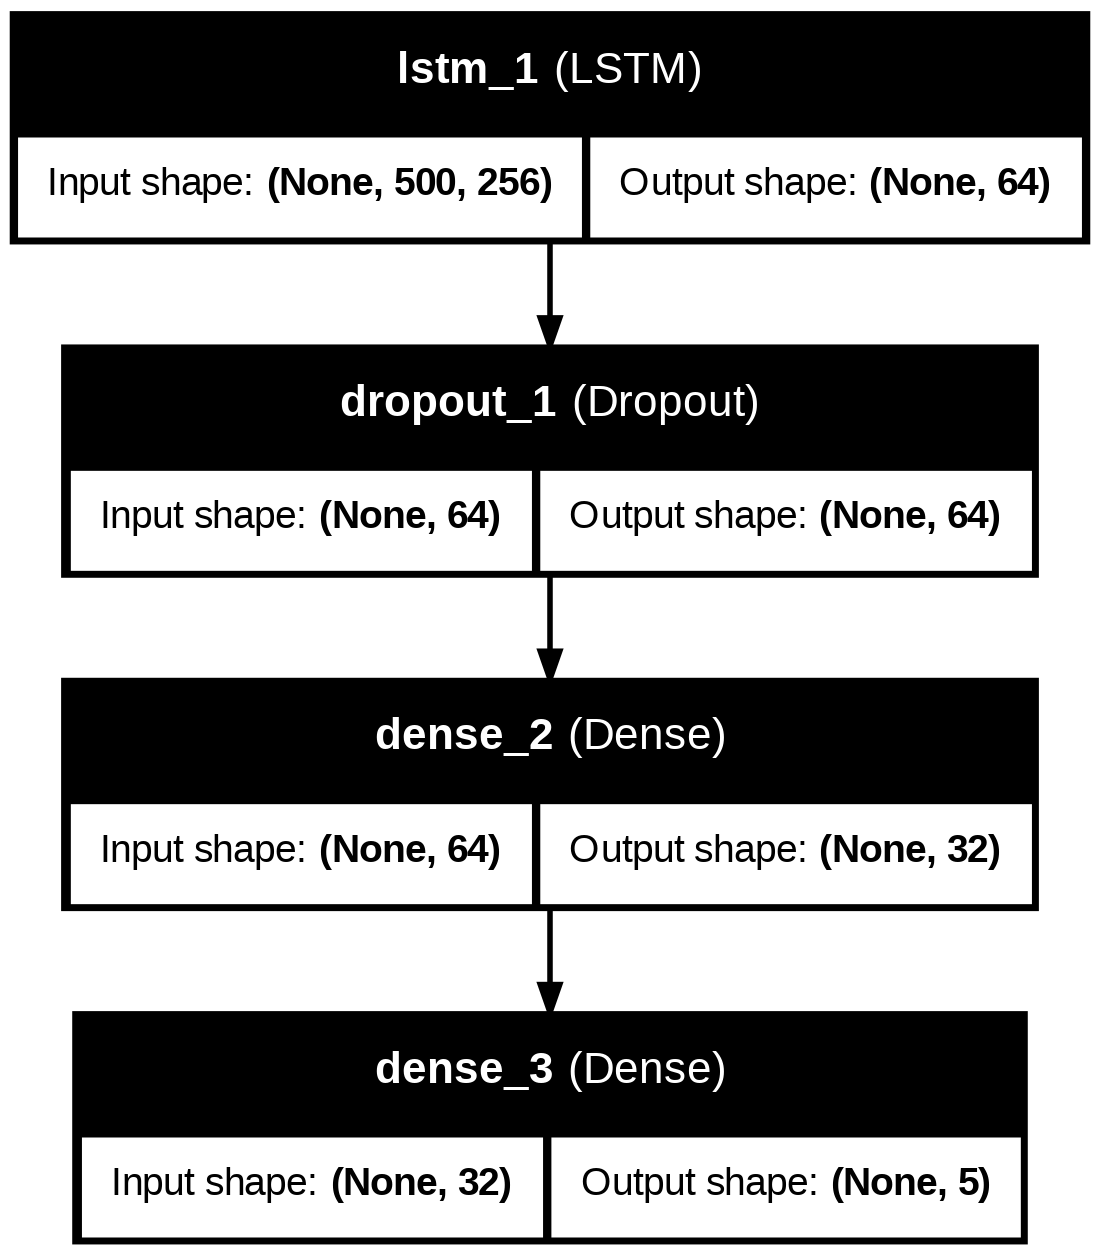

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)

## LSTM Model Training

In [24]:
history = model.fit(X_train, y_train_en, epochs= 100, batch_size=16, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.3240 - loss: 1.5363 - val_accuracy: 0.6354 - val_loss: 1.0862
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.6920 - loss: 0.9628 - val_accuracy: 0.7865 - val_loss: 0.6623
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.8453 - loss: 0.5597 - val_accuracy: 0.8490 - val_loss: 0.4111
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.9293 - loss: 0.2774 - val_accuracy: 0.9271 - val_loss: 0.2288
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9688 - loss: 0.1770 - val_accuracy: 0.9635 - val_loss: 0.1240
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9767 - loss: 0.0998 - val_accuracy: 0.9583 - val_loss: 0.1485
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.9907 - loss: 0.0548 - val_accuracy: 0.8698 - val_loss: 0.8486
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - accuracy: 0.8717 - loss: 0.6659 - va

## Model Evaluation

In [25]:
y_pred = model.predict(X_test) #prediction on test data set

model.evaluate(X_test, y_test_en)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9688 - loss: 0.0830


[0.09287506341934204, 0.9668049812316895]

# Model History plot

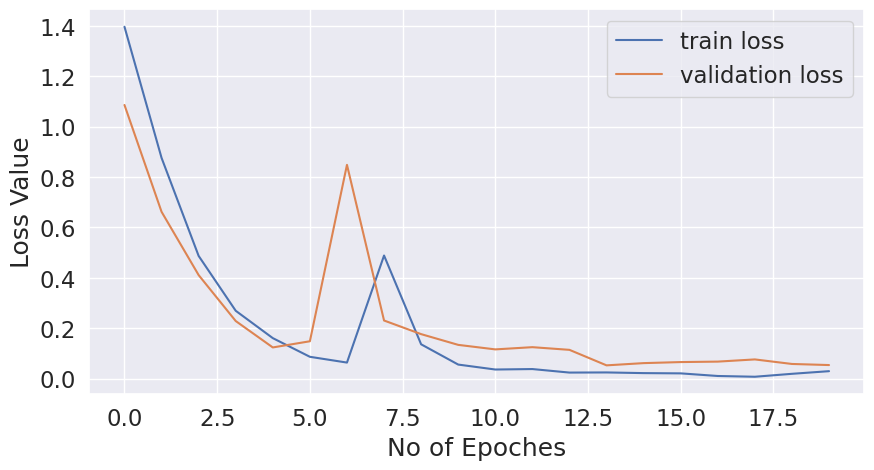

In [26]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

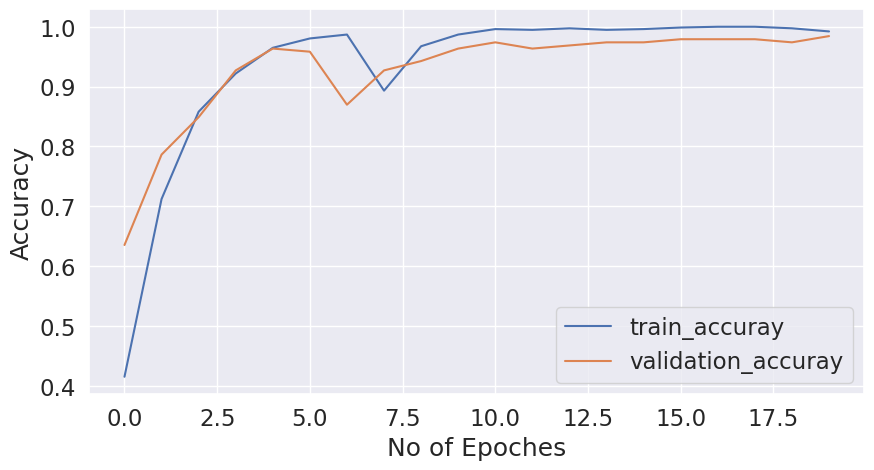

In [27]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuray')
plt.plot(history.history['val_accuracy'], label='validation_accuray')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

# Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'Lying', 'Sitting','Standing','Walking']
columns = ['Empty', 'Lying', 'Sitting','Standing','Walking']
df_cm = pd.DataFrame(confusion_matrix,columns,index)

Text(0.5, 13.249999999999995, 'Predicted Activities')

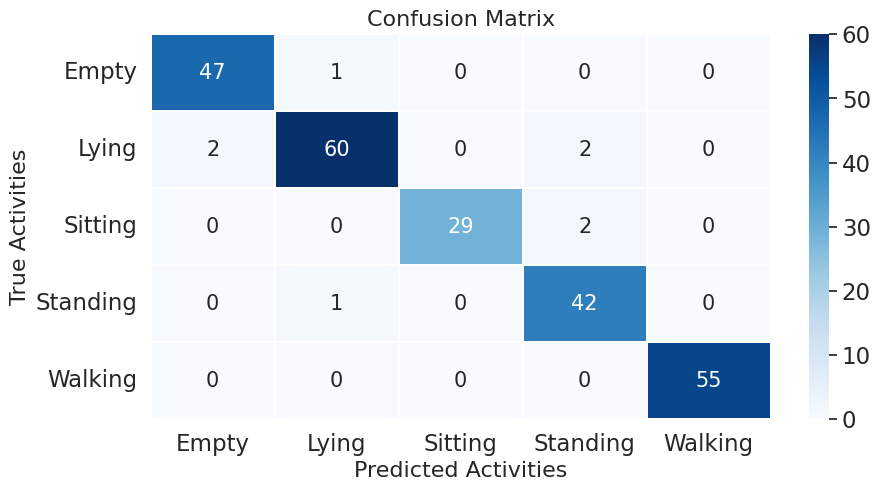

In [29]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [30]:
# Classification Report
from sklearn.metrics import classification_report
target_names = ['Empty', 'Lying', 'Sitting','Standing','Walking']
print(classification_report(np.argmax(y_test_en, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

       Empty       0.96      0.98      0.97        48
       Lying       0.97      0.94      0.95        64
     Sitting       1.00      0.94      0.97        31
    Standing       0.91      0.98      0.94        43
     Walking       1.00      1.00      1.00        55

    accuracy                           0.97       241
   macro avg       0.97      0.97      0.97       241
weighted avg       0.97      0.97      0.97       241

